In [12]:
%matplotlib inline

# Standard imports
import copy
import itertools

# Scientific computing imports
import numpy
import matplotlib.pyplot as plt
import networkx as nx
import pandas
import collections
from bisect import bisect
from networkx.algorithms.flow import edmonds_karp

import seaborn; seaborn.set()

# Import widget methods
from IPython.html.widgets import *

In [2]:
class Ant(object):
    """
    Ant class, which encapsulates the entire behavior of an ant.
    """
    def __init__(self,model,ant_id):
    
        # Set model link and ID
        self.model = model
        self.ant_id = ant_id
        
    def random_walk(self,s,t):
        #Random Walk
        #initialize
        self.source=s
        self.sink=t
        self.g=nx.DiGraph()
        self.last_nodes=[]
        self.last_nodes.append(self.source)


        #Agent Step
        #print('looping')
        while self.sink not in self.g:
            for i in xrange(len(self.last_nodes)):
                #get neighbors
                self.base_node=self.last_nodes.pop()
                self.p_neighbors=self.get_neighbors(self.base_node)
                
                #get pheromone of each edge to neighbor
                self.edge_pheromone_list=[]
                for self.potential_node in self.p_neighbors:
                    self.edge_pheromone_list.append(self.get_pheromone_edge((self.base_node,self.potential_node)))
                
                #get next node
                self.next_node=self.p_neighbors[self.make_decision(self.edge_pheromone_list)]
                self.last_nodes.insert(0,self.next_node)
                
                #add edge
                self.g.add_edge(self.base_node,self.next_node)
                #print(self.g.nodes())
                
                #Check termination criteria
                #currently in while loop
                #to be updated to check all sinks.
                

        return (self.g)
    
    def get_neighbors(self,node):
        """
        Return neighbors, calling through model.
        """
        return self.model.get_ant_neighbors(node)
    
    def make_decision(self,pheromone_list):
        """
        Return decision index, based on pheromone list.
        """
        #convert pheromones to percentage
        self.percent_list = [float(i)/sum(pheromone_list) for i in pheromone_list]   
        self.cumulative_percent=numpy.cumsum(self.percent_list)

        #Choose decision index
        self.select_index=bisect(self.cumulative_percent,numpy.random.uniform(0,1,1))
  
        return self.select_index
    
    
    #def get_pheromone_node(self,node):
        """
        Return node pheromone, calling through model.
        """    
    
    
    def get_pheromone_edge(self,edge):
        """
        Return edge pheromone, calling through model.
        """
        return self.model.get_edge_pheromone(edge)
    

    def __repr__(self):
        '''
        Return string representation.
        '''
        skip_none = True
        repr_string = type(self).__name__ + " ["
        except_list = "model"

        elements = [e for e in dir(self) if str(e) not in except_list]
        for e in elements:
            # Make sure we only display "public" fields; skip anything private (_*), that is a method/function, or that is a module.
            if not e.startswith("_") and eval('type(self.{0}).__name__'.format(e)) not in ['DataFrame', 'function', 'method', 'builtin_function_or_method', 'module', 'instancemethod']:
                    value = eval("self." + e)
                    if value != None and skip_none == True:
                        repr_string += "{0}={1}, ".format(e, value)

        # Clean up trailing space and comma.
        return repr_string.strip(" ").strip(",") + "]"

    

In [101]:
class Space(object):
    """
    Space class, which encapsulates the entire behavior of a single "run" ACO.
    """
    def __init__(self, size,num_ants=1,source=(0,0),sink=(3,3),dissipation=.8,pheromone_drop=.5):
        """
        Class constructor.
        """
        # Set our model parameters
        self.size = size
        self.sink = sink
        self.source=source
        self.num_ants=num_ants
        self.dissipation=dissipation
        self.pheromone_drop=pheromone_drop
        
        # Set our state variables
        self.t = 0
        self.ants = []

        
        # Call our setup methods to initialize space, people, and institution.
        self.setup_space()
        self.setup_ants()
        

    def setup_space(self):
        """
        Method to setup our space.
        """
        # Initialize a space with a grid network
        self.g = nx.grid_graph(dim=[self.size,self.size])
        self.g=self.g.to_directed()
        
        #Set Pheromones
        print('Setting up network')
        for e in self.g.edges_iter():
            self.g.add_edge(e[0],e[1],capacity=0)
            self.g.add_edge(e[0],e[1],edge_pheromone=1)
            self.g.add_edge(e[0],e[1],capacity_pheromone=[(1,1),(2,1)])
            #print(self.g[e[0]][e[1]])

        self.g_layout = nx.spectral_layout(self.g)

        #nx.draw_networkx(self.g, pos=self.g_layout, node_color='#dddddd')
        #print((self.g.number_of_nodes(), self.g.number_of_edges()))

        #plt.show() 
        
    def setup_ants(self):
        """
        Method to setup our space.
        """
        
        # First, begin by creating all ants.
        for i in xrange(self.num_ants):
            self.ants.append(Ant(model=self,ant_id=i))
            
    def get_edge_pheromone(self,edge):
        """
        Get edge decision pheromone for ant call
        """        
        return self.g[edge[0]][edge[1]]['edge_pheromone']
        
        
    def get_ant_neighbors(self,node):
        """
        Get node neighbors for ant call
        """
        return self.g.neighbors(node)
            
    def get_path(self, ant_id):
        """
        Get the path of an ant based on their ID.
        """
        return self.ants[ant_id].random_walk(self.source,self.sink)
    
    def evaluate_graph(self, ant_graph):
        """
        Score graphs based on criteria.
        """
        score=ant_graph.number_of_edges()
        return score
        
        
    def ant_ranking(self, ant_graphs):
        """
        Find best Ants based on scores from evaluate_graph.
        """
        score_list=[]
        [score_list.append(graph[1]) for graph in ant_graphs]
        print(score_list)
        
        best_ants_index=[]
        [best_ants_index.append(i) for i, j in enumerate(score_list) if j == min(score_list)]
        return best_ants_index, score_list
        
    def step(self):
        """
        Model step function.
        """
        #Ants make paths
        self.ant_graphs=[]
        
        #Step for each ant
        for i in xrange(self.num_ants):
            self.ant_graph=self.get_path(i)
            #Evaluate Paths
            self.graph_score=self.evaluate_graph(self.ant_graph)            
            
            #List <graph,score>
            self.ant_graphs.append((self.ant_graph,self.graph_score))
            
        #Get best score
        self.opt_ant,self.score_list=self.ant_ranking(self.ant_graphs)
        #print('Best ants:',self.opt_ant,'Score:',self.ant_graphs[self.opt_ant[0]][1])
        
        #Update Institutions - Edges Only for this walk
        #Get edge pheromones
        self.edge_pheromone_dict=nx.get_edge_attributes(self.g,'edge_pheromone')
        
        #Get edge list of best ant paths
        self.best_ant_edge_set=set() #use set to get only unique values (each edge listed once)
        for ant in self.opt_ant:
            #print(ant)
            #print(self.ant_graphs[ant][0].edges())
            for e in self.ant_graphs[ant][0].edges():
                self.best_ant_edge_set.add(e)
            
            
        self.best_ant_edge_list=list(self.best_ant_edge_set)
                                      
        #Reduce pheromones by input amount
        for key in self.edge_pheromone_dict:    
            self.edge_pheromone_dict[key]*=self.dissipation
            
            #increase the pheromone amount of edges traveled by best ants
            if key in self.best_ant_edge_list:
                self.edge_pheromone_dict[key]+=self.pheromone_drop
        
        #Set new edge pheromones
        nx.set_edge_attributes(self.g, 'edge_pheromone', self.edge_pheromone_dict)
        
        
            
        
            

        
                                      

In [3]:
space=Space(size=4,num_ants=5,sink=(2,2),pheromone_drop=.3)
nx.draw_networkx(space.g, pos=space.g_layout, node_color='#dddddd')
#print((space.g.number_of_nodes(), space.g.number_of_edges()))

plt.show()  

space.step()

print('Ant Path')
#print(space.ant_graphs[0])
#print(space.ant_graphs[0][0].edges())

#p_el=[]

#for i in range(0,len(space.ant_paths[0])-1):
   # p_el.append((space.ant_paths[0][i],space.ant_paths[0][i+1]))
    

# Remove the infected from healthy nodes
nonpath_nodes = [node for node in space.g.nodes() if node not in space.ant_graphs[space.opt_ant[0]][0]]

for u,v in space.g.edges():
    print(space.g[u][v]['edge_pheromone'])

# Now we can visualize the infected node's position
f = plt.figure()
nx.draw_networkx_nodes(space.ant_graphs[space.opt_ant[0]][0], space.g_layout,
                       node_color='red',edge_color='red')

nx.draw_networkx_nodes(space.g, space.g_layout,
                       nodelist=nonpath_nodes,
                       node_color='#dddddd')

nx.draw_networkx_edges(space.g, space.g_layout, 
                       width=1.0, 
                       alpha=0.5,
                       edge_color='#111111')

nx.draw_networkx_edges(space.ant_graphs[space.opt_ant[0]][0], space.g_layout,
                      edgelist=space.ant_graphs[space.opt_ant[0]][0].edges(),
                      width=1.0, 
                      alpha=0.5,
                      edge_color='red')


_ = nx.draw_networkx_labels(space.g, space.g_layout,
                        dict(zip(space.g.nodes(), space.g.nodes())),
                        font_size=10)

NameError: name 'Space' is not defined

1
[17, 21, 11, 11, 24]
2
[15, 6, 7, 17, 8]
3
[25, 7, 26, 10, 6]
4
[33, 7, 10, 6, 8]
5
[6, 7, 12, 14, 13]
6
[12, 4, 6, 10, 6]
7
[15, 4, 5, 7, 14]
8
[10, 6, 4, 4, 4]
9
[4, 4, 4, 4, 15]
10
[6, 7, 4, 4, 4]
11
[4, 4, 5, 4, 6]
12
[4, 4, 14, 7, 6]
13
[4, 4, 5, 6, 4]
14
[4, 4, 4, 5, 4]
15
[4, 4, 4, 4, 4]
Ant Path
0.0281474976711
0.0413416372044
0.0281474976711
1.43954060437
0.0413416372044
0.622494850348
0.057834311621
0.0281474976711
0.0281474976711
0.0281474976711
0.057834311621
0.0413416372044
0.0413416372044
0.0281474976711
0.0281474976711
0.0281474976711
0.0281474976711
0.0281474976711
0.0281474976711
0.0281474976711
0.0281474976711
0.0281474976711
0.0281474976711
0.719960344468
0.0281474976711
0.0413416372044
0.057834311621
0.0281474976711
0.0281474976711
0.673574697671
0.560389623248
1.45887826512
0.0281474976711
0.0281474976711
0.0413416372044
0.0281474976711
0.0281474976711
0.0281474976711
0.0281474976711
0.673574697671
0.0281474976711
1.45887826512
0.057834311621
0.0413416372044
0.11

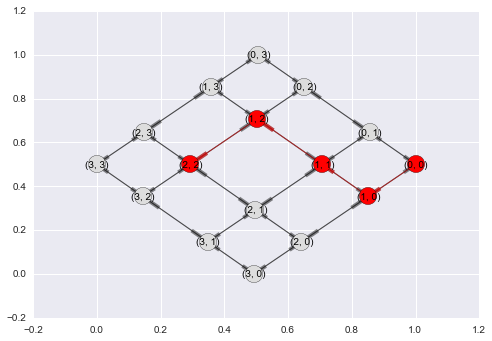

In [107]:
converged=0
i=1
while not converged:
    print(i)
    space.step()
    i+=1
    
    scores=space.score_list
    #check convergence
    if all(scores[0] == item for item in scores):
        converged=1
    
    if i>50:
        converged=1
        

print('Ant Path')
#print(space.ant_graphs[0])
#print(space.ant_graphs[0][0].edges())

#p_el=[]

#for i in range(0,len(space.ant_paths[0])-1):
   # p_el.append((space.ant_paths[0][i],space.ant_paths[0][i+1]))
    

# Remove the infected from healthy nodes
nonpath_nodes = [node for node in space.g.nodes() if node not in space.ant_graphs[space.opt_ant[0]][0]]

for u,v in space.g.edges():
    print(space.g[u][v]['edge_pheromone'])

# Now we can visualize the infected node's position
f = plt.figure()
nx.draw_networkx_nodes(space.ant_graphs[space.opt_ant[0]][0], space.g_layout,
                       node_color='red',edge_color='red')

nx.draw_networkx_nodes(space.g, space.g_layout,
                       nodelist=nonpath_nodes,
                       node_color='#dddddd')

nx.draw_networkx_edges(space.g, space.g_layout, 
                       width=1.0, 
                       alpha=0.5,
                       edge_color='#111111')

nx.draw_networkx_edges(space.ant_graphs[space.opt_ant[0]][0], space.g_layout,
                      edgelist=space.ant_graphs[space.opt_ant[0]][0].edges(),
                      width=1.0, 
                      alpha=0.5,
                      edge_color='red')


_ = nx.draw_networkx_labels(space.g, space.g_layout,
                        dict(zip(space.g.nodes(), space.g.nodes())),
                        font_size=10)

In [6]:
g = nx.grid_graph(dim=[1,2])

g=g.to_directed()

g.add_edge((0,0),(0,1),capacity=0)
g.add_edge((0,0),(0,1),edge_pheromone=1)
g.add_edge((0,0),(0,1),capacity_pheromone=[1,2])
print(g.nodes())
print(g.edges())
print(g[(0,0)][(0,1)]['capacity'])
g[(0,0)][(0,1)]



[(0, 1), (0, 0)]
[((0, 1), (0, 0)), ((0, 0), (0, 1))]
0


{'capacity': 0, 'capacity_pheromone': [1, 2], 'edge_pheromone': 1}

In [63]:
#Pheromone test

l=[.1,.2,.2]
nl=[0]
for i in xrange(len(l)):
    nl.append(l[i]/sum(l))

print(nl)

[0.2, 0.4, 0.4]


In [34]:
from bisect import bisect
g = nx.grid_graph(dim=[2,2])

g=g.to_directed()

for e in g.edges_iter():
    #print(e)
    g.add_edge(e[0],e[1],capacity=0)
    g.add_edge(e[0],e[1],edge_pheromone=1)
    g.add_edge(e[0],e[1],capacity_pheromone=[(1,1),(2,1)])
    #print(g[e[0]][e[1]])

#print(g.nodes())
node=(0,0)
n_neighbors=g.neighbors(node)
#print(n_neighbors)
epl=[]

#Get pheromone for each neighbor edge
for n in n_neighbors:
    #print(n)
    edge=(node,n)
    #print(edge)
    pheromone=g[edge[0]][edge[1]]['edge_pheromone']
    epl.append((edge,pheromone))
    
print(epl)

#convert pheromone to percentage
epherl=[]
for i in xrange(len(epl)):
    epherl.append(epl[i][1])
print(epherl)
    
epercl = [float(i)/sum(epherl) for i in epherl]   
print(epercl)

ecumsum=numpy.cumsum(epercl)
print(ecumsum)

#select node
#random_select=numpy.random.uniform(0,1,1)
#print(random_select)
index=bisect(ecumsum,numpy.random.uniform(0,1,1))
print(index)
next_node=n_neighbors[index]
print(n_neighbors)
print(next_node)
print(node in g)

[(((0, 0), (0, 1)), 1), (((0, 0), (1, 0)), 1)]
[1, 1]
[0.5, 0.5]
[ 0.5  1. ]
1
[(0, 1), (1, 0)]
(1, 0)
True


In [22]:
g=nx.DiGraph()
g.add_edge(1,2)
g.add_edge(1,2)
print(g.edges())

[(1, 2)]


In [10]:
q=[1,2,3,4]
print(q)
while q:
    next_node=q.pop()
    print(next_node)
    
print(q)

[1, 2, 3, 4]
4
3
2
1
[]


In [46]:
#Flow on graph

G = nx.DiGraph()
G.add_edge('x','a', capacity=3.0)
G.add_edge('x','b', capacity=1.0)
G.add_edge('a','c', capacity=3.0)
G.add_edge('b','c', capacity=5.0)
G.add_edge('b','d', capacity=4.0)
G.add_edge('d','e', capacity=2.0)
G.add_edge('c','y', capacity=2.0)
G.add_edge('e','y', capacity=3.0)

e_cap=nx.get_edge_attributes(G,'capacity')
print(e_cap)
for e in G.edges():
    print(e_cap[e])
    
print(G.edges())
flow_value, flow_dict = nx.maximum_flow(G, 'x', 'y')
flow_value
R = edmonds_karp(G, 'x', 'y')
for u, v in G.edges_iter():
     print('(%s, %s) %.2f' % (u, v, R[u][v]['flow']))
 

{('b', 'c'): 5.0, ('d', 'e'): 2.0, ('x', 'a'): 3.0, ('e', 'y'): 3.0, ('c', 'y'): 2.0, ('x', 'b'): 1.0, ('a', 'c'): 3.0, ('b', 'd'): 4.0}
3.0
2.0
5.0
4.0
3.0
2.0
3.0
1.0
[('a', 'c'), ('c', 'y'), ('b', 'c'), ('b', 'd'), ('e', 'y'), ('d', 'e'), ('x', 'a'), ('x', 'b')]
(a, c) 2.00
(c, y) 2.00
(b, c) 0.00
(b, d) 1.00
(e, y) 1.00
(d, e) 1.00
(x, a) 2.00
(x, b) 1.00


In [41]:


my_list=[0,4,2,4,3,0]
max_value = max(my_list)
max_index = my_list.index(max_value)
print(max_index)
ind=my_list.index(max(my_list))
print(ind)

index=[]
[index.append(i) for i, j in enumerate(my_list) if j == max(my_list)]

print(index)


1
1
[1, 3]


In [61]:
#How to update graph attributes

G = nx.DiGraph()
G.add_edge('x','a', capacity=3.0)
G.add_edge('x','b', capacity=1.0)
G.add_edge('a','c', capacity=3.0)
G.add_edge('b','c', capacity=5.0)
G.add_edge('b','d', capacity=4.0)
G.add_edge('d','e', capacity=2.0)
G.add_edge('c','y', capacity=2.0)
G.add_edge('e','y', capacity=3.0)


e_list=[('b','c'),('x','a')]
e_cap=nx.get_edge_attributes(G,'capacity')
print(e_cap)
for key in e_cap:    
    e_cap[key] *=  2
    if key in e_list:
        print('found match')
        e_cap[key]+=1
    
print(e_cap)
nx.set_edge_attributes(G, 'capacity', e_cap)
for u,v in G.edges_iter():    
    print(G.edge[u][v]['capacity'])


{('b', 'c'): 5.0, ('d', 'e'): 2.0, ('x', 'a'): 3.0, ('e', 'y'): 3.0, ('c', 'y'): 2.0, ('x', 'b'): 1.0, ('a', 'c'): 3.0, ('b', 'd'): 4.0}
found match
found match
{('b', 'c'): 11.0, ('d', 'e'): 4.0, ('x', 'a'): 7.0, ('e', 'y'): 6.0, ('c', 'y'): 4.0, ('x', 'b'): 2.0, ('a', 'c'): 6.0, ('b', 'd'): 8.0}
6.0
4.0
11.0
8.0
6.0
4.0
7.0
2.0


In [94]:
import collections
compare = lambda x, y: collections.Counter(x) == collections.Counter(y)
compare([1,2,3],[1,2,3])

True

In [7]:
#How to update graph attributes

G = nx.Graph()
G.add_edge('x','a', capacity=3.0)
G.add_edge('x','b', capacity=1.0)
G.add_edge('a','c', capacity=3.0)
G.add_edge('b','c', capacity=5.0)
G.add_edge('b','d', capacity=4.0)
G.add_edge('d','e', capacity=2.0)
G.add_edge('c','y', capacity=2.0)
G.add_edge('e','y', capacity=3.0)


e_list=[('b','c'),('x','a')]
e_cap=nx.get_edge_attributes(G,'capacity')
print(e_cap)
for key in e_cap:    
    e_cap[key] *=  2
    if key in e_list:
        print('found match')
        e_cap[key]+=1
    
print(e_cap)
nx.set_edge_attributes(G, 'capacity', e_cap)
for u,v in G.edges_iter():    
    print(G.edge[u][v]['capacity'])
    
print(G.edges())
flow_value, flow_dict = nx.maximum_flow(G, 'x', 'y')
print(flow_value)
R = edmonds_karp(G, 'x', 'y')
for u, v in G.edges_iter():
     print('(%s, %s) %.2f' % (u, v, R[u][v]['flow']))
 

{('b', 'x'): 1.0, ('a', 'x'): 3.0, ('e', 'd'): 2.0, ('c', 'b'): 5.0, ('e', 'y'): 3.0, ('c', 'y'): 2.0, ('a', 'c'): 3.0, ('b', 'd'): 4.0}
{('b', 'x'): 2.0, ('a', 'x'): 6.0, ('e', 'd'): 4.0, ('c', 'b'): 10.0, ('e', 'y'): 6.0, ('c', 'y'): 4.0, ('a', 'c'): 6.0, ('b', 'd'): 8.0}
6.0
6.0
4.0
10.0
2.0
8.0
6.0
4.0
[('a', 'x'), ('a', 'c'), ('c', 'y'), ('c', 'b'), ('b', 'x'), ('b', 'd'), ('e', 'y'), ('e', 'd')]
8.0
(a, x) -6.00
(a, c) 6.00
(c, y) 4.00
(c, b) 2.00
(b, x) -2.00
(b, d) 4.00
(e, y) 4.00
(e, d) -4.00


In [27]:
G = nx.Graph()   # or DiGraph, MultiGraph, MultiDiGraph, etc
G.add_path([0,1,2])
t=G.has_node([0,2])
print(t)
print(G.nodes())

g=nx.Graph()
i=0
t=0
nodes=[1,2,4]
while not t:
    t=1
    g.add_node(i)
    for n in nodes:
        if n not in g:
            t=0
    if i >50:
        break
    print(i)
    i+=1
    
print(g.nodes())

False
[0, 1, 2]
0
1
2
3
4
[0, 1, 2, 3, 4]
